In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Load dataset from directory
dataset_dir = '/content/drive/MyDrive/dataset'
batch_size = 32
img_size = (224, 224)

dataset = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                       image_size=img_size,
                                       batch_size=batch_size,
                                       label_mode='int')

Found 4227 files belonging to 4 classes.


In [ ]:
def load_images_from_folder(folder, num_images=3):
    images = []
    filenames = os.listdir(folder)
    for filename in filenames[:num_images]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img)
    return images

def visualize_dataset(dataset_dir, num_images=5):
    class_names = os.listdir(dataset_dir)
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, num_images, figsize=(num_images * 3, num_classes * 3))
    fig.suptitle('Dataset Visualization', fontsize=16)

    for class_idx, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_dir, class_name)
        images = load_images_from_folder(class_folder, num_images)
        for img_idx, img in enumerate(images):
            ax = axes[class_idx, img_idx]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(class_name, fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

visualize_dataset(dataset_dir)

In [ ]:
def apply_clahe(img):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to an image.
    """
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert from RGB to LAB color space
    l, a, b = cv2.split(img_lab)  # Split the LAB image to different channels
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)  # Apply CLAHE to the L-channel
    img_lab = cv2.merge((cl, a, b))  # Merge the CLAHE enhanced L-channel with the a and b channel
    img_clahe = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)  # Convert from LAB to RGB color space
    return img_clahe

In [ ]:
# Load images and labels from directory
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(directory, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = apply_clahe(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels), class_names

# Load data
images, labels, class_names = load_images_from_directory(dataset_dir)

# Print the class names
print("Class names:", class_names)

# Verify the shapes of images and labels
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Class names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Images shape: (4227, 224, 224, 3)
Labels shape: (4227,)


In [ ]:
# Split data using sklearn train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
from keras import layers, applications, models, optimizers, callbacks
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

def preprocess_and_augment(image, label):
    image = data_augmentation(image)
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.xception.preprocess_input(image)
    return image, label

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.xception.preprocess_input(image)
    return image, label

# Convert to TensorFlow datasets and apply augmentation to training data
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .map(preprocess_and_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

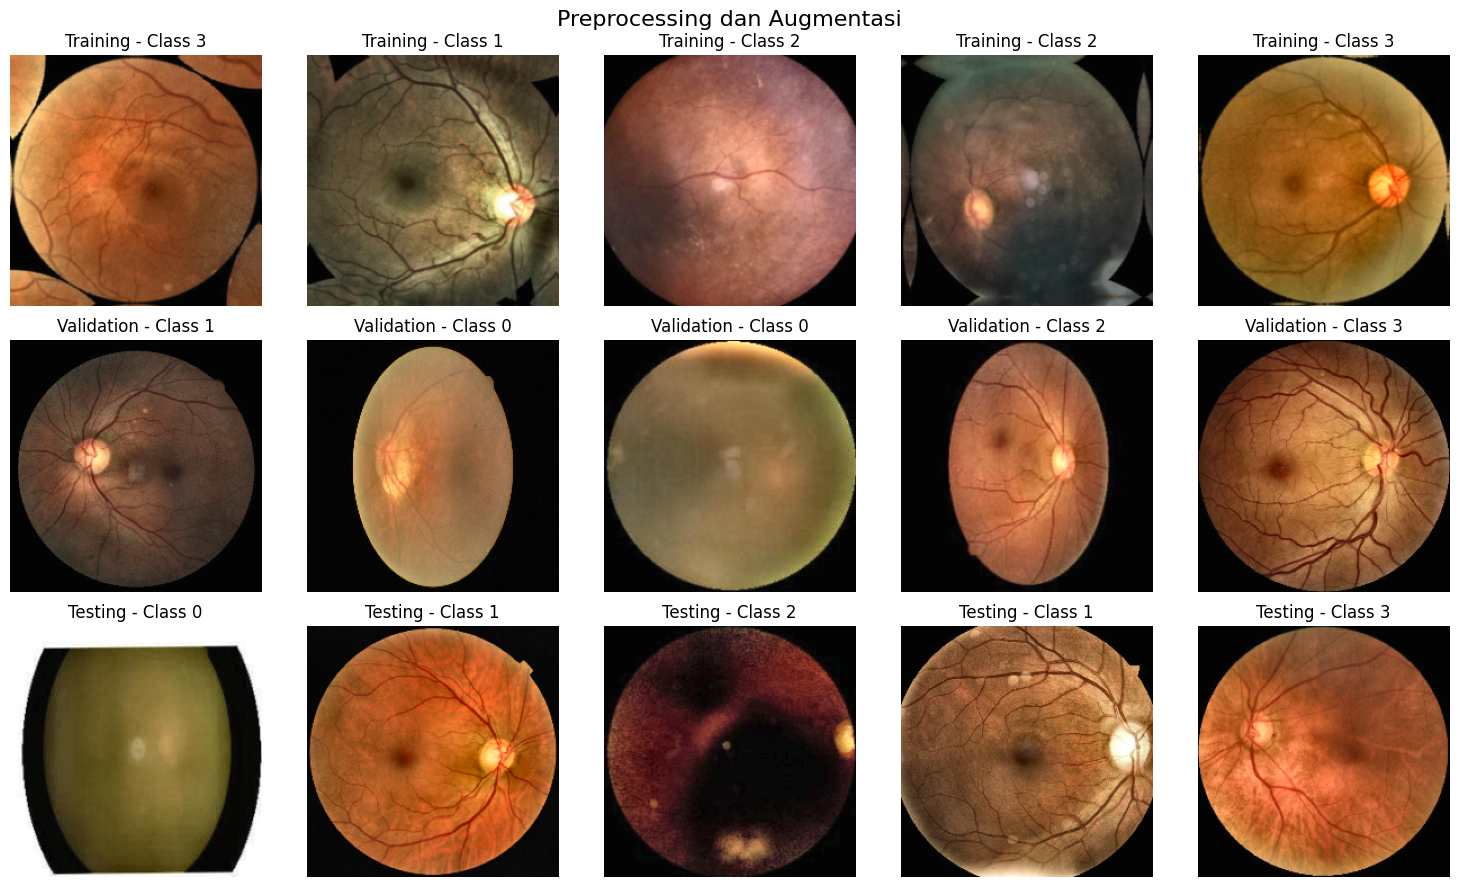

In [ ]:
import matplotlib.pyplot as plt

# Visualize dataset
def visualize_dataset_from_split(train_ds, val_ds, test_ds, num_images=5):
    datasets = {'Training': train_ds, 'Validation': val_ds, 'Testing': test_ds}
    fig, axes = plt.subplots(len(datasets), num_images, figsize=(num_images * 3, len(datasets) * 3))
    fig.suptitle('Preprocessing dan Augmentasi', fontsize=16)

    for ds_idx, (ds_name, ds) in enumerate(datasets.items()):
        for images, labels in ds.take(1):
            for img_idx in range(num_images):
                ax = axes[ds_idx, img_idx]

                # Revert preprocessing for visualization
                image = images[img_idx].numpy()

                # If the preprocessing changed the range to [-1, 1], we need to scale it back to [0, 255]
                if image.min() < 0:
                    image = (image + 1.0) * 127.5
                else:
                    image = image * 255.0

                # Convert image to uint8 for display
                image = image.astype("uint8")

                ax.imshow(image)
                ax.axis('off')
                ax.set_title(f"{ds_name} - Class {labels[img_idx].numpy()}", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

visualize_dataset_from_split(train_ds, val_ds, test_ds)

In [ ]:
# Load the EfficientNetB5 model with pretrained weights
base_model = Xception(weights='imagenet',
                            include_top=False,
                            input_shape=(img_size[0], img_size[1], 3))

for layer in base_model.layers:
    layer.trainable = False

# Add new layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # Assuming 4 classes

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary(show_trainable=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_2          │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1 (Conv2D)  │ (None, 111, 111, 32) │          864 │ input_layer_2[0][0] │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1_bn        │ (None, 111, 111, 32) │          128 │ block1_conv1[0][0]  │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1_act       │ (None, 111, 111, 32) │            0 │ block1_conv1_bn[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2 (Conv2D)  │ (None, 109, 109, 64) │       18,432 │ block1_conv1_act[0… │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2_bn        │ (None, 109, 109, 64) │          256 │ block1_conv2[0][0]  │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2_act       │ (None, 109, 109, 64) │            0 │ block1_conv2_bn[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv1        │ (None, 109, 109,     │        8,768 │ block1_conv2_act[0… │    N    │
│ (SeparableConv2D)      │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv1_bn     │ (None, 109, 109,     │          512 │ block2_sepconv1[0]… │    N    │
│ (BatchNormalization)   │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2_act    │ (None, 109, 109,     │            0 │ block2_sepconv1_bn… │    -    │
│ (Activation)           │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2        │ (None, 109, 109,     │       17,536 │ block2_sepconv2_ac… │    N    │
│ (SeparableConv2D)      │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2_bn     │ (None, 109, 109,     │          512 │ block2_sepconv2[0]… │    N    │
│ (BatchNormalization)   │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 55, 55, 128)  │        8,192 │ block1_conv2_act[0… │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_pool            │ (None, 55, 55, 128)  │            0 │ block2_sepconv2_bn… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├──────────────────────

 Total params: 23,486,508 (89.59 MB)

 Trainable params: 2,625,028 (10.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

In [ ]:
# Train the model on the new data for a few epochs
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.5456 - loss: 1.1139
Epoch 1: val_loss improved from inf to 0.71848, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 87s 710ms/step - accuracy: 0.5465 - loss: 1.1118 - val_accuracy: 0.7319 - val_loss: 0.7185
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7183 - loss: 0.7023
Epoch 2: val_loss improved from 0.71848 to 0.66383, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 422ms/step - accuracy: 0.7184 - loss: 0.7019 - val_accuracy: 0.7350 - val_loss: 0.6638
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7345 - loss: 0.6639
Epoch 3: val_loss improved from 0.66383 to 0.65602, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 405ms/step - accuracy: 0.7345 - loss: 0.6638 - val_accuracy: 0.7429 - val_loss: 0.6560
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7598 - loss: 0.6068
Epoch 4: val_loss did not improve from 0.65602
93/9

In [ ]:
# Tahap kedua: Unfreeze model dasar untuk fine-tuning, kecuali lapisan BatchNormalization
for layer in base_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary(show_trainable=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_2          │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1 (Conv2D)  │ (None, 111, 111, 32) │          864 │ input_layer_2[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1_bn        │ (None, 111, 111, 32) │          128 │ block1_conv1[0][0]  │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1_act       │ (None, 111, 111, 32) │            0 │ block1_conv1_bn[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2 (Conv2D)  │ (None, 109, 109, 64) │       18,432 │ block1_conv1_act[0… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2_bn        │ (None, 109, 109, 64) │          256 │ block1_conv2[0][0]  │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2_act       │ (None, 109, 109, 64) │            0 │ block1_conv2_bn[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv1        │ (None, 109, 109,     │        8,768 │ block1_conv2_act[0… │    Y    │
│ (SeparableConv2D)      │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv1_bn     │ (None, 109, 109,     │          512 │ block2_sepconv1[0]… │    N    │
│ (BatchNormalization)   │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2_act    │ (None, 109, 109,     │            0 │ block2_sepconv1_bn… │    -    │
│ (Activation)           │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2        │ (None, 109, 109,     │       17,536 │ block2_sepconv2_ac… │    Y    │
│ (SeparableConv2D)      │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2_bn     │ (None, 109, 109,     │          512 │ block2_sepconv2[0]… │    N    │
│ (BatchNormalization)   │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 55, 55, 128)  │        8,192 │ block1_conv2_act[0… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_pool            │ (None, 55, 55, 128)  │            0 │ block2_sepconv2_bn… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├──────────────────────

 Total params: 23,486,508 (89.59 MB)

 Trainable params: 23,377,452 (89.18 MB)

 Non-trainable params: 109,056 (426.00 KB)

In [ ]:
# Fine-tune the model
fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks
)

# Load the best model
model.load_weights('best_model.keras')

Epoch 10/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8000 - loss: 0.4765
Epoch 10: val_loss improved from 0.58971 to 0.53644, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 114s 909ms/step - accuracy: 0.8001 - loss: 0.4762 - val_accuracy: 0.8139 - val_loss: 0.5364
Epoch 11/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.8414 - loss: 0.4065
Epoch 11: val_loss improved from 0.53644 to 0.52310, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 104s 688ms/step - accuracy: 0.8415 - loss: 0.4063 - val_accuracy: 0.8265 - val_loss: 0.5231
Epoch 12/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.8723 - loss: 0.3236
Epoch 12: val_loss improved from 0.52310 to 0.43506, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 81s 680ms/step - accuracy: 0.8724 - loss: 0.3236 - val_accuracy: 0.8580 - val_loss: 0.4351
Epoch 13/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.8861 - loss: 0.3011
Epoch 13: val_loss improved from 0.435

20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 559ms/step
Classification Report:
                       precision    recall  f1-score   support

            cataract       0.97      0.93      0.95       156
diabetic_retinopathy       0.95      0.98      0.96       165
            glaucoma       0.92      0.81      0.87       151
              normal       0.83      0.93      0.88       163

            accuracy                           0.91       635
           macro avg       0.92      0.91      0.91       635
        weighted avg       0.92      0.91      0.91       635

Confusion Matrix:
 [[145   0   7   4]
 [  0 161   0   4]
 [  3   1 123  24]
 [  1   7   3 152]]


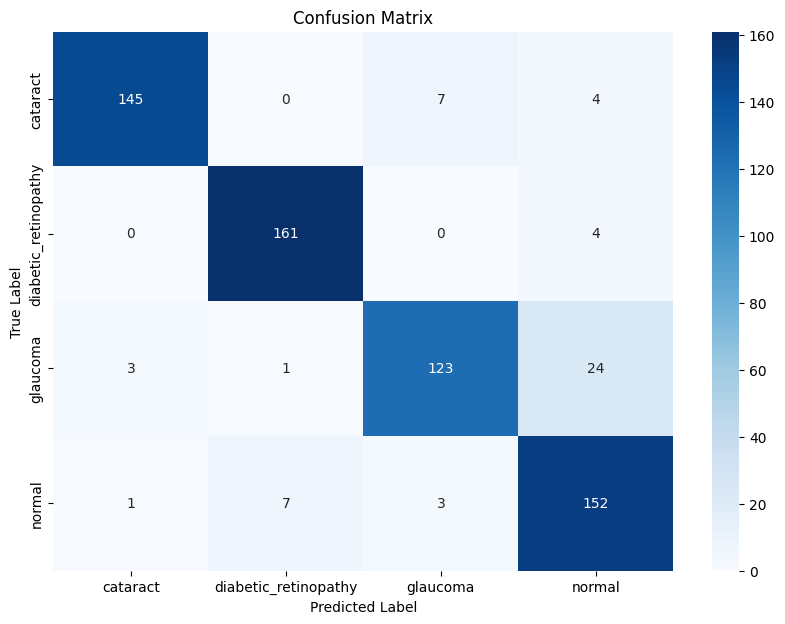

In [ ]:
# Predict labels for the test set
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate classification report
report = classification_report(y_test, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Optional: visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

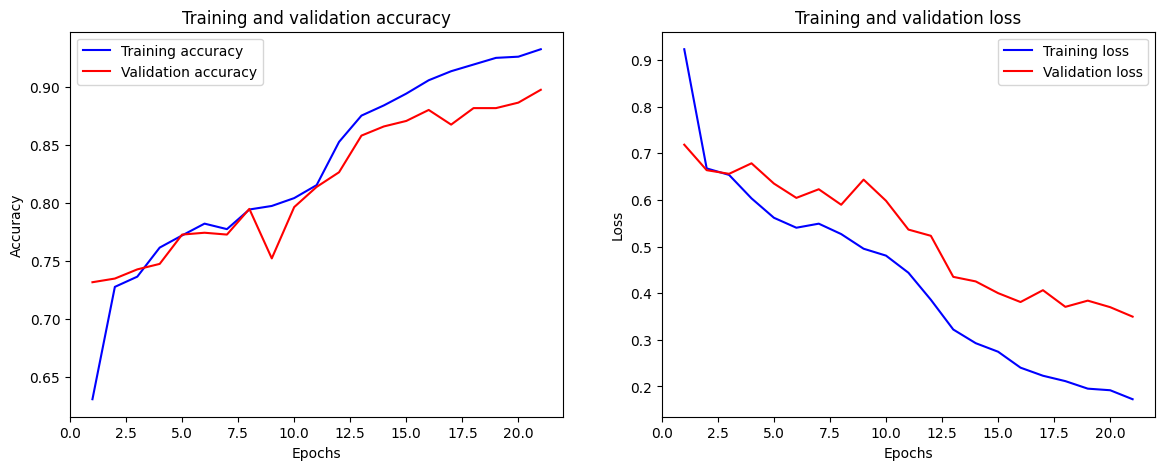

In [ ]:
# Plotting the training history
def plot_training_history(history, fine_tune=False):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if fine_tune:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')  # Menambahkan teks sumbu X
    plt.ylabel('Accuracy')  # Menambahkan teks sumbu Y
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')  # Menambahkan teks sumbu X
    plt.ylabel('Loss')  # Menambahkan teks sumbu Y
    plt.legend()

    plt.show()

# Plotting the training and fine-tuning history
plot_training_history(history, fine_tune=True)

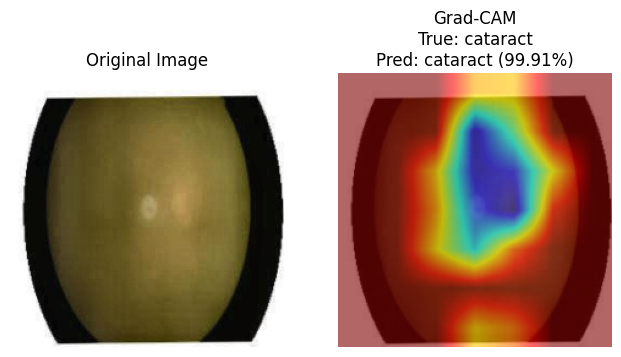

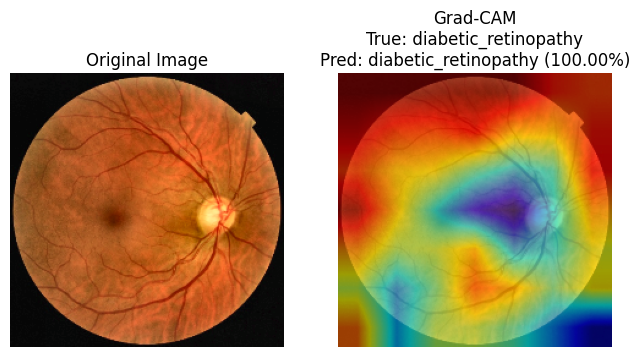

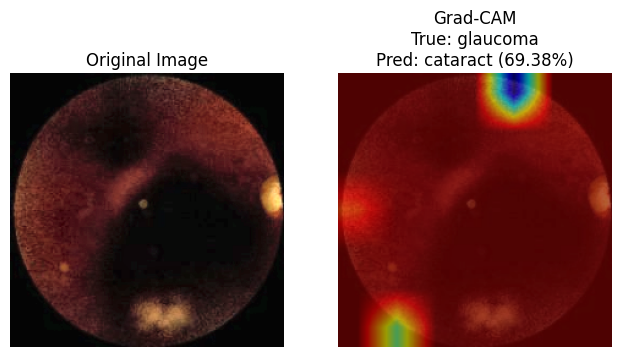

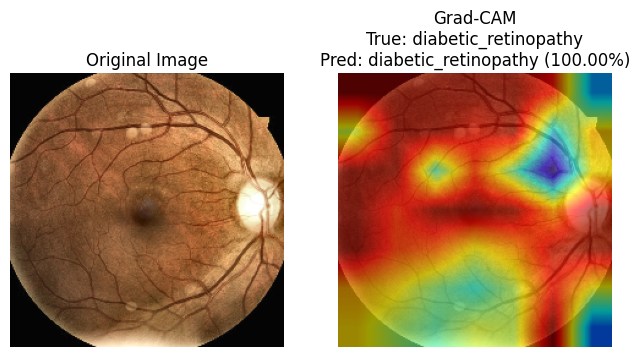

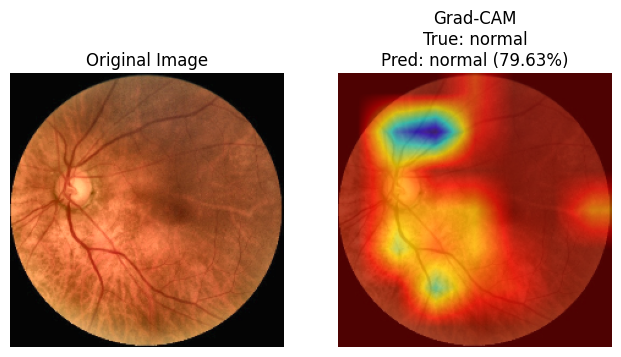

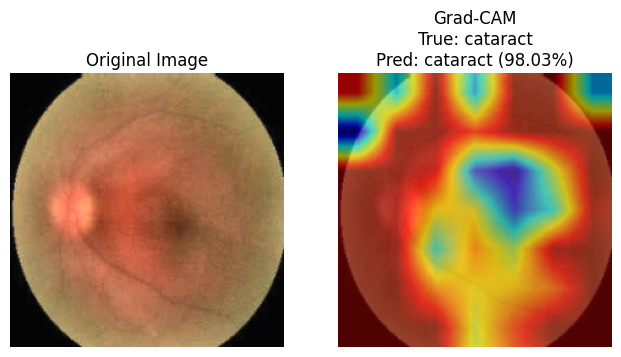

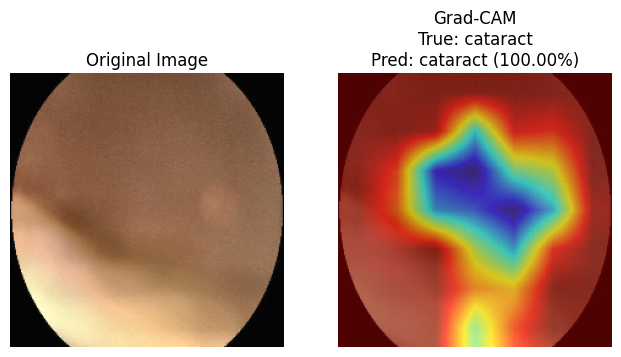

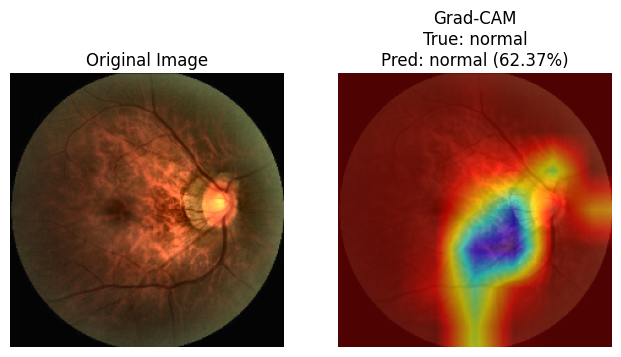

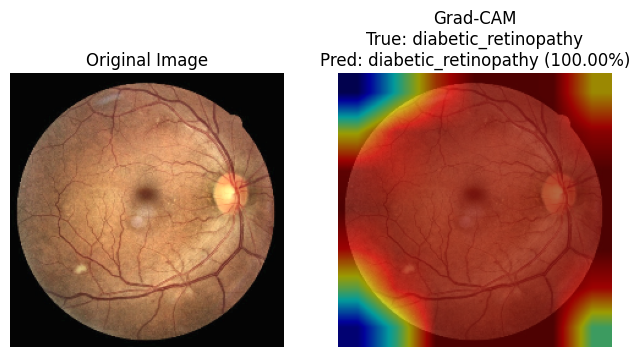

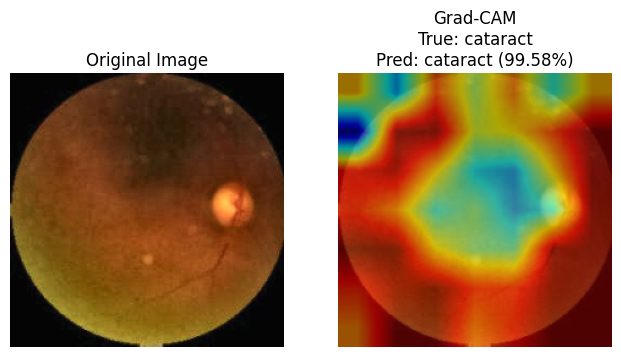

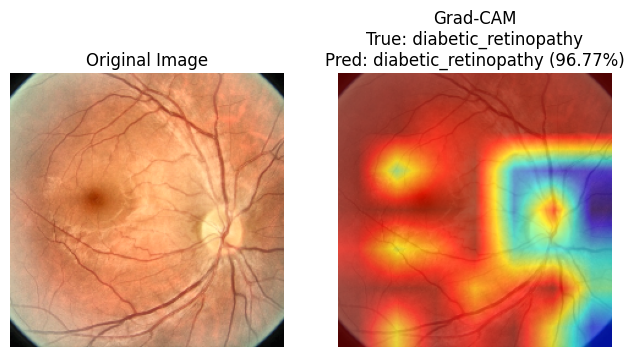

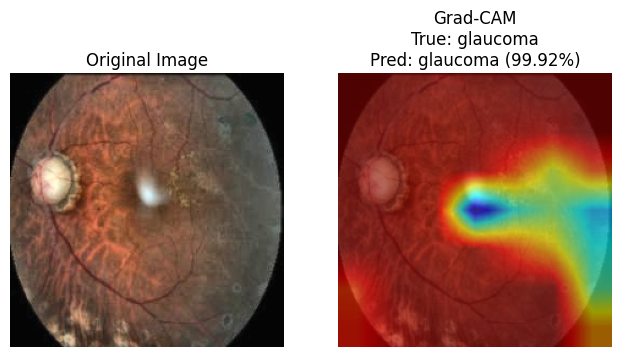

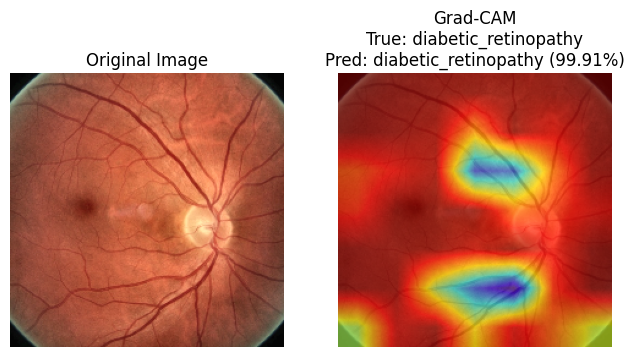

In [ ]:
def get_gradcam_heatmap(model, img_array, class_index, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, predictions[0]

def apply_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return overlay

# Nama layer konvolusi terakhir dalam model
last_conv_layer_name = "conv2d_3"

# Definisikan label kelas secara manual
class_labels = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# Ambil beberapa gambar dari set tes untuk visualisasi
sample_test_images = X_test[:13]
sample_test_labels = y_test[:13]

# Rescale gambar jika diperlukan
sample_test_images_rescaled = sample_test_images / 255.0

for i in range(len(sample_test_images)):
    img_array = np.expand_dims(sample_test_images_rescaled[i], axis=0)
    true_class_index = sample_test_labels[i]
    heatmap, predictions = get_gradcam_heatmap(model, img_array, true_class_index, last_conv_layer_name)

    # Apply heatmap to the original image
    original_img = sample_test_images[i]
    heatmap_img = apply_heatmap(original_img, heatmap)

    # Get the class label and prediction
    true_label = class_labels[true_class_index]
    pred_class_index = np.argmax(predictions)
    pred_label = class_labels[pred_class_index]
    pred_percentage = predictions[pred_class_index] * 100

    # Plot original and heatmap images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Grad-CAM\nTrue: {true_label}\nPred: {pred_label} ({pred_percentage:.2f}%)")
    plt.imshow(heatmap_img)
    plt.axis('off')

    plt.show()